In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from copy import deepcopy, copy
import sqlite3
#from test import sensitivity_plots

/home/iwsatlas1/llorente/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_selected = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_raw_tito_testFile5_light.csv')
df_selected_new = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_northern_light.csv')
df_retrained_from_northern = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_from_northern_epoch17_light.csv')
df_40e = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_from_northern_epoch40_light.csv')

database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'

In [4]:
all_df = [df_selected, df_selected_new, df_40e]
all_labels = ['Raw model', 'First retrain', 'Epoch 40 retrain']

In [9]:
opening_angle.percentile_calculations['tracks'][opening_angle.df_labels[1]]['colour']

'tab:blue'

Text(0, 0.5, 'Count')

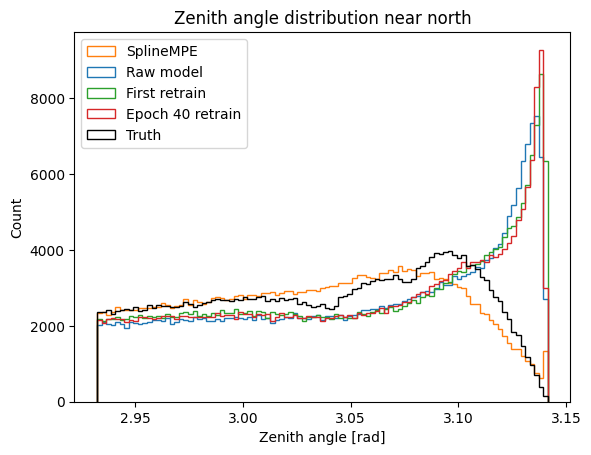

In [10]:
bins = np.linspace(np.pi-np.pi/15, np.pi, 100)
colors = ['blue', 'red', 'green', 'black']
labels = ['raw']

plt.hist(opening_angle.df_original[0]['zenith_spline_mpe_ic'], bins=bins, histtype='step', color=opening_angle.percentile_calculations['tracks'][opening_angle.df_labels[0]]['colour'], label=(opening_angle.df_labels[0]))
for idx, df_i in enumerate(opening_angle.df_original[1:]):
    plt.hist(df_i['zenith_pred'], bins=bins, histtype='step', color=opening_angle.percentile_calculations['tracks'][opening_angle.df_labels[idx+1]]['colour'], label=(opening_angle.df_labels[idx+1]))
    
plt.hist(df_i['zenith'], bins=bins, histtype='step', color='black', label='Truth')
plt.legend()

plt.title('Zenith angle distribution near north')
plt.xlabel('Zenith angle [rad]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

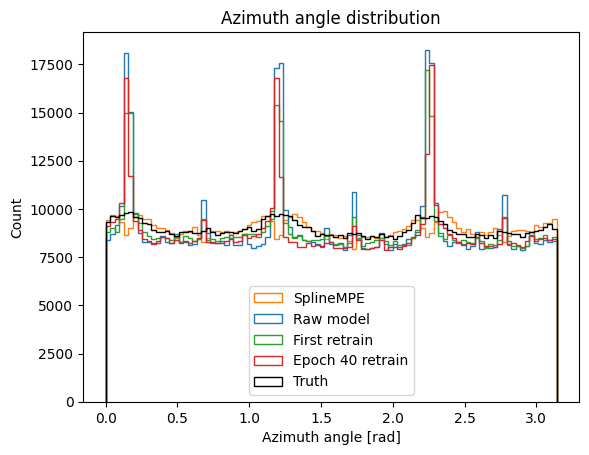

In [11]:

bins = np.linspace(0, np.pi, 100)
colors = ['blue', 'red', 'green', 'black']
labels = ['raw']

plt.hist(opening_angle.df_original[0]['azimuth_spline_mpe_ic'], bins=bins, histtype='step', color=opening_angle.percentile_calculations['tracks'][opening_angle.df_labels[0]]['colour'], label=(opening_angle.df_labels[0]))
for idx, df_i in enumerate(opening_angle.df_original[1:]):
    plt.hist(df_i['azimuth_pred'], bins=bins, histtype='step', color=opening_angle.percentile_calculations['tracks'][opening_angle.df_labels[idx+1]]['colour'], label=(opening_angle.df_labels[idx+1]))
    
plt.hist(df_i['azimuth'], bins=bins, histtype='step', color='black', label='Truth')
plt.legend()

plt.title('Azimuth angle distribution')
plt.xlabel('Azimuth angle [rad]')
plt.ylabel('Count')

<Axes: title={'center': 'Opening angle resolution on NT dataset'}, xlabel='True Energy [GeV]', ylabel='Opening Angle [deg.]'>

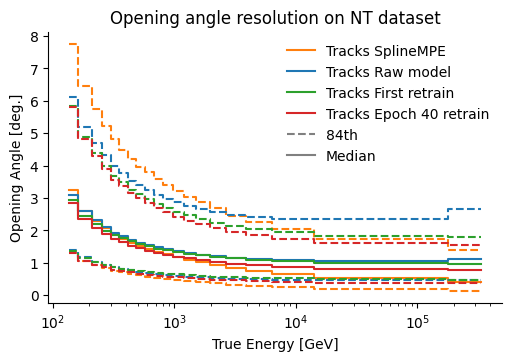

In [8]:
opening_angle = sensitivity_plots_jupyter(all_df, all_labels, database, cascades_in_dataset=False)
opening_angle.plot_resolution_fancy('direction', include_residual_hist=False)


Text(0.5, 1.0, 'Opening angle counts')

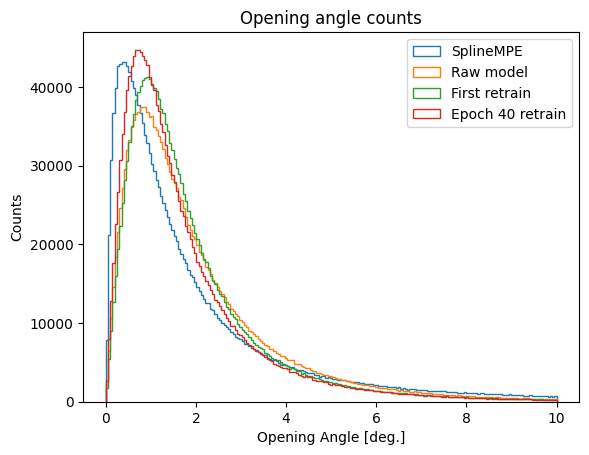

In [12]:
bins=np.linspace(0, 10, 200)
for label in opening_angle.residual.keys():
    plt.hist(opening_angle.residual[label], bins=bins, histtype = 'step', label = label)
plt.legend()
plt.xlabel('Opening Angle [deg.]')
plt.ylabel('Counts')
plt.title('Opening angle counts')

Text(0.5, 1.0, 'Opening angle counts until 1 deg')

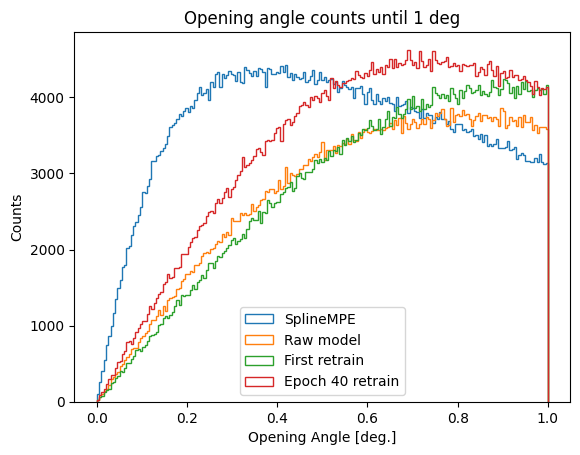

In [13]:
bins=np.linspace(0, 1, 200)
for label in opening_angle.residual.keys():
    plt.hist(opening_angle.residual[label], bins=bins, histtype = 'step', label = label)
plt.legend()
plt.xlabel('Opening Angle [deg.]')
plt.ylabel('Counts')
plt.title('Opening angle counts until 1 deg')

<Axes: title={'center': 'Azimuth resolution on NT dataset'}, xlabel='True Energy [GeV]', ylabel='Zenith Resolution [deg.]'>

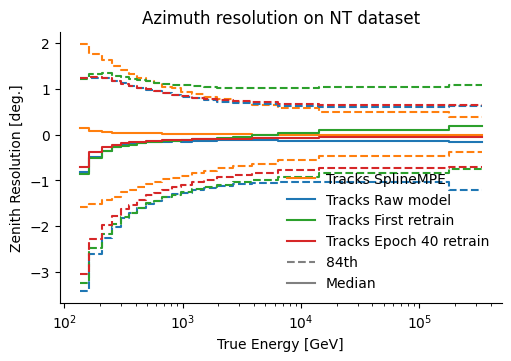

In [14]:
zenith = sensitivity_plots_jupyter(all_df, all_labels, database, cascades_in_dataset=False)
zenith.plot_resolution_fancy('zenith', include_residual_hist=False)

Text(0.5, 1.0, 'Azimuth counts')

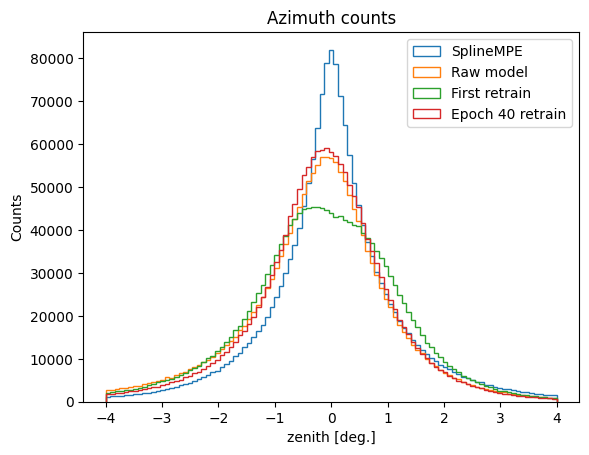

In [15]:
bins=np.linspace(-4, 4, 100)
for label in zenith.residual.keys():
    plt.hist(zenith.residual[label], bins=bins, histtype = 'step', label = label)
#plt.hist(np.rad2deg(zenith.df_original[0]['zenith']), bins=bins, histtype = 'step', label = 'truth')
plt.legend()
plt.xlabel('zenith [deg.]')
plt.ylabel('Counts')
plt.title('Azimuth counts')

Text(0.5, 1.0, 'zenith counts until 1 deg')

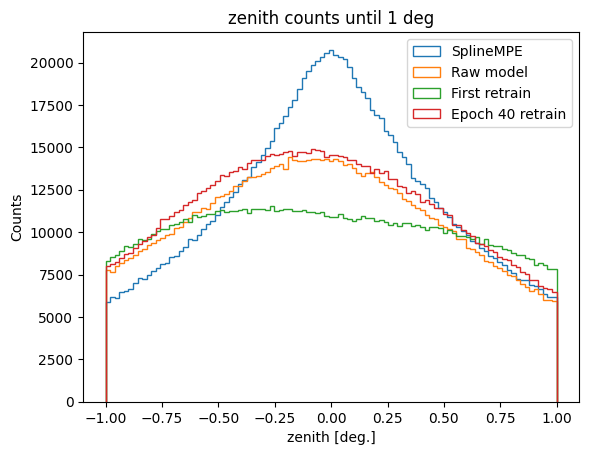

In [16]:
bins=np.linspace(-1, 1, 100)
for label in zenith.residual.keys():
    plt.hist(zenith.residual[label], bins=bins, histtype = 'step', label = label)
plt.legend()
plt.xlabel('zenith [deg.]')
plt.ylabel('Counts')
plt.title('zenith counts until 1 deg')

<Axes: title={'center': 'Zenith resolution on NT dataset'}, xlabel='True Energy [GeV]', ylabel='Zenith Resolution [deg.]'>

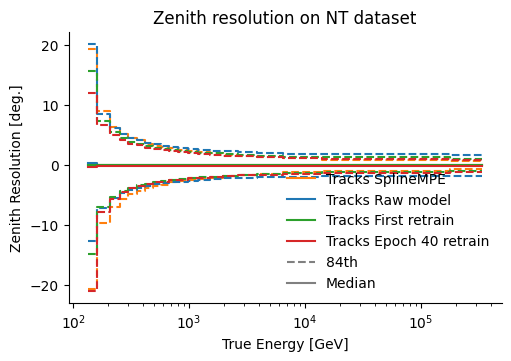

In [17]:
azimuth = sensitivity_plots_jupyter(all_df, all_labels, database, cascades_in_dataset=False)
azimuth.plot_resolution_fancy('azimuth', include_residual_hist=False)

In [18]:
azimuth_hig_energy = sensitivity_plots_jupyter(all_df, all_labels, database, cascades_in_dataset=False)


Text(0.5, 1.0, 'Azimuth counts')

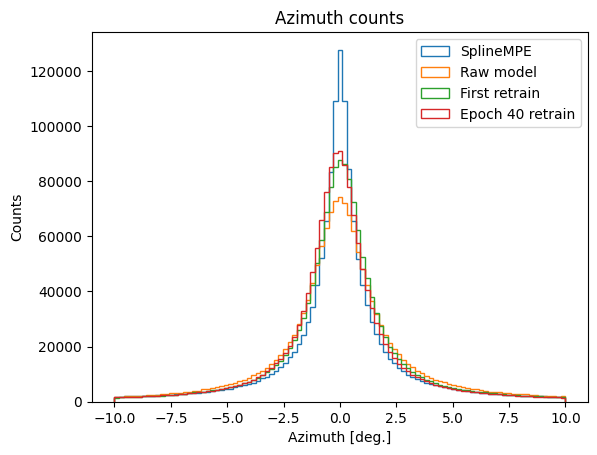

In [19]:
bins=np.linspace(-10, 10, 100)
for label in azimuth.residual.keys():
    plt.hist(azimuth.residual[label], bins=bins, histtype = 'step', label = label)
plt.legend()
plt.xlabel('Azimuth [deg.]')
plt.ylabel('Counts')
plt.title('Azimuth counts')

Text(0.5, 1.0, 'Azimuth counts until 1 deg')

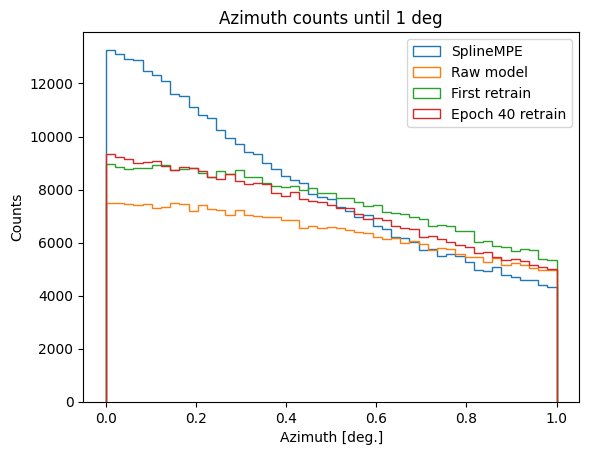

In [20]:
bins=np.linspace(0, 1, 50)
for label in azimuth.residual.keys():
    plt.hist(azimuth.residual[label], bins=bins, histtype = 'step', label = label)
plt.legend()
plt.xlabel('Azimuth [deg.]')
plt.ylabel('Counts')
plt.title('Azimuth counts until 1 deg')

Text(0.5, 1.0, 'Azimuth counts until 1 deg')

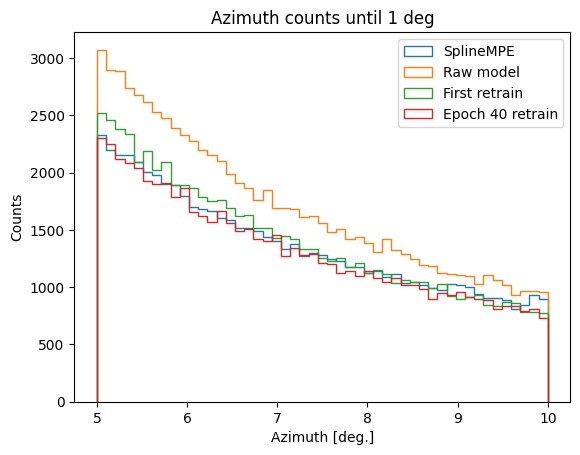

In [21]:
bins=np.linspace(5, 10, 50)
for label in azimuth.residual.keys():
    plt.hist(azimuth.residual[label], bins=bins, histtype = 'step', label = label)
plt.legend()
plt.xlabel('Azimuth [deg.]')
plt.ylabel('Counts')
plt.title('Azimuth counts until 1 deg')

In [ ]:
def opening_angle(self, df, key = 'gnn'):
    x = np.cos(df['azimuth']) * np.sin(df['zenith'])
    y = np.sin(df['azimuth']) * np.sin(df['zenith'])
    z = np.cos(df['zenith'])
    if key == 'gnn':
        dot_product = x*df[self.x_pred_label] + y*df[self.y_pred_label] + z*df[self.z_pred_label]
        norm = np.sqrt(df[self.x_pred_label]**2 + df[self.y_pred_label]**2 + df[self.z_pred_label]**2)
        angle = np.arccos(dot_product/norm)
    elif key == 'spline':
        x_spline = np.cos(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
        y_spline = np.sin(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
        z_spline = np.cos(df['zenith_spline_mpe_ic'])
        dot_product = x*x_spline + y*y_spline + z*z_spline
        norm = np.sqrt(x_spline**2 + y_spline**2 + z_spline**2)
        angle = np.arccos(dot_product/norm)
    return np.rad2deg(angle)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from copy import deepcopy
from typing import Union, List
import warnings

class sensitivity_plots_jupyter:
    def __init__(self, 
                 df_original: Union[pd.DataFrame, List[pd.DataFrame]], 
                 df_labels: Union[str, List[str]],
                 db: str,
                 pulsemaps:str = 'InIceDSTPulses',
                 index_column: str = 'event_no',
                 x_pred_label: str = 'direction_x',
                 y_pred_label: str = 'direction_y',
                 z_pred_label: str = 'direction_z',
                 truth_table = 'truth',
                 compare_spline: bool = True,
                 cascades_in_dataset: bool = False):
        if isinstance(df_original, pd.DataFrame):
            df_original = [df_original]
        if not isinstance(df_original, list):
            raise TypeError('df_original must be a pandas DataFrame or a list of DataFrames')
        if not isinstance(db, str):
            raise TypeError('database must be a string')
        
        self.db = db
        self.pulsemaps = pulsemaps
        self.index_column = index_column
        self.x_pred_label = x_pred_label
        self.y_pred_label = y_pred_label
        self.z_pred_label = z_pred_label
        self.truth_table = truth_table
        self.compare_spline = compare_spline
        self.cascades_in_dataset = cascades_in_dataset
        df_new = copy(df_original)
        df_labels_new = copy(df_labels)
        
        if compare_spline:
            df_new.insert(0, df_new[-1])
            df_labels_new.insert(0, 'SplineMPE')
        
        self.df_labels = deepcopy(df_labels_new)
        if 'energy' not in df_new[0].columns:
            df_new = self._add_energy(df_new)
        if 'track' not in df_new[0].columns:
            df_new = self._add_track_label(df_new)
        if 'azimuth_pred' not in df_new[0].columns:
            df_new = [self._add_prediction_azimuth_zenith(df_i) if ('zenith_pred' not in df_i.columns) else df_i for df_i in df_new]
        if self.compare_spline:
            df_new[0] = self._add_spline_fit(df_new[0])
    
        self.df_original = deepcopy(df_new)
       
    def _add_energy(self, original_df: List[pd.DataFrame]):
        df = deepcopy(original_df)
        df = [df_i.sort_values(self.index_column).reset_index(drop = True) for df_i in df]
        
        if all((df_i[self.index_column] == df[0][self.index_column]).all() for df_i in df[1:]):
            with sqlite3.connect(self.db) as con:
                query = f'select {self.index_column}, energy from {self.truth_table} where {self.index_column} in {str(tuple(df[0][self.index_column]))}'
                truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
        else:
            warnings.warn('The DataFrames do not have the same index', UserWarning)
            for idx, df_i in enumerate(df):
                with sqlite3.connect(self.db) as con:
                    query = f'select {self.index_column}, energy from {self.truth_table} where {self.index_column} in {str(tuple(df_i[self.index_column]))}'
                    truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
                    
        for idx, df_i in enumerate(df):
            for column in truth.columns:
                if column not in df_i.columns:
                    df[idx][column] = truth[column]
        return df
    
    def _add_track_label(self, original_df: List[pd.DataFrame]):
        df = deepcopy(original_df)
        df = [df_i.sort_values(self.index_column).reset_index(drop = True) for df_i in df]
        
        if all((df_i[self.index_column] == df[0][self.index_column]).all() for df_i in df[1:]):
            with sqlite3.connect(self.db) as con:
                query = f'select {self.index_column}, interaction_type, pid from {self.truth_table} where {self.index_column} in {str(tuple(df[0][self.index_column]))}'
                truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
                truth['track'] = 0
                truth.loc[(truth['interaction_type'] == 1) & (abs(truth['pid']) == 14), 'track'] = 1
        else:
            warnings.warn('The DataFrames do not have the same index', UserWarning)
            for idx, df_i in enumerate(df):
                with sqlite3.connect(self.db) as con:
                    query = f'select {self.index_column}, interaction_type, pid from {self.truth_table} where {self.index_column} in {str(tuple(df_i[self.index_column]))}'
                    truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
                    truth['track'] = 0
                    truth.loc[(truth['interaction_type'] == 1) & (abs(truth['pid']) == 14), 'track'] = 1
                            
        for idx, df_i in enumerate(df):
            for column in truth.columns:
                if column not in df_i.columns:
                    df[idx][column] = truth[column]
        
        return df

    def _add_spline_fit(self, original_df: pd.DataFrame):
        df = deepcopy(original_df)
        df = df.sort_values(self.index_column).reset_index(drop = True)
        with sqlite3.connect(self.db) as con:
            # Read the table data into a Pandas DataFrame
            query = f'SELECT {self.index_column}, zenith_spline_mpe_ic, azimuth_spline_mpe_ic from spline_mpe_ic where {self.index_column} in {str(tuple(df[self.index_column]))}'
            truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
            # Add the spline fit to the DataFrame
            for column in truth.columns:
                if column not in df.columns:
                    df[column] = truth[column]    
        return df
        
    def _add_prediction_azimuth_zenith(self, original_df):
        df = deepcopy(original_df)
        df = df.sort_values(self.index_column).reset_index(drop = True)
            
        magnitude = np.sqrt(df[self.x_pred_label]**2 + df[self.y_pred_label]**2 + df[self.z_pred_label]**2)
        zenith_pred = np.arccos(df[self.z_pred_label] / magnitude)
        azimuth_pred = np.arctan2(df[self.y_pred_label], df[self.x_pred_label])
        
        zenith_pred = np.where(zenith_pred < 0, 2*np.pi + zenith_pred, zenith_pred)
        azimuth_pred = np.where(azimuth_pred < 0, 2*np.pi + azimuth_pred, azimuth_pred)
        df['zenith_pred'] = np.where(zenith_pred >= 2*np.pi, zenith_pred - 2*np.pi, zenith_pred)
        df['azimuth_pred'] = np.where(azimuth_pred >= 2*np.pi, azimuth_pred - 2*np.pi, azimuth_pred)
        
        return df


    def _calculate_percentiles(self, percentile_calculations_original, residual, key1, key2, index = None):
        percentile_calculations = deepcopy(percentile_calculations_original)
        if index is None:
            percentile_calculations[key1][key2]['p_16'].append(np.percentile(residual, 16))
            percentile_calculations[key1][key2]['p_84'].append(np.percentile(residual, 84))
            if self.include_median:
                percentile_calculations[key1][key2]['p_50'].append(np.percentile(residual, 50))
            return percentile_calculations
        else:
            if sum(index)>0:
                percentile_calculations[key1][key2]['p_16'].append(np.percentile(residual[index], 16))
                percentile_calculations[key1][key2]['p_84'].append(np.percentile(residual[index], 84))
                if self.include_median:
                    percentile_calculations[key1][key2]['p_50'].append(np.percentile(residual[index], 50))
                return percentile_calculations
            else:
                percentile_calculations[key1][key2]['p_16'].append(np.nan)
                percentile_calculations[key1][key2]['p_84'].append(np.nan)
                if self.include_median:
                    percentile_calculations[key1][key2]['p_50'].append(np.nan)
                return percentile_calculations

    def _calculate_opening_angle(self, df, key = 'gnn'):
        x = np.cos(df['azimuth']) * np.sin(df['zenith'])
        y = np.sin(df['azimuth']) * np.sin(df['zenith'])
        z = np.cos(df['zenith'])
        if key == 'gnn':
            dot_product = x*df[self.x_pred_label] + y*df[self.y_pred_label] + z*df[self.z_pred_label]
            norm = np.sqrt(df[self.x_pred_label]**2 + df[self.y_pred_label]**2 + df[self.z_pred_label]**2)
            angle = np.arccos(dot_product/norm)
        elif key == 'spline':
            x_spline = np.cos(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
            y_spline = np.sin(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
            z_spline = np.cos(df['zenith_spline_mpe_ic'])
            dot_product = x*x_spline + y*y_spline + z*z_spline
            norm = np.sqrt(x_spline**2 + y_spline**2 + z_spline**2)
            angle = np.arccos(dot_product/norm)
        return np.rad2deg(angle)

    def plot_variable_count(self, key, fill = True, font_size = 10):
        df = self.df_original
        fig = plt.figure(figsize = (5,3.5), constrained_layout = True)
        ax = fig.add_subplot(111)
        if key == 'energy':
            key_bins = np.arange(0,3.5, 0.1)
            ax.set_xlabel('True Energy [GeV]', size = font_size)
            ax.set_ylabel('Reco. Energy [GeV]', size = font_size)

        if key == 'zenith':
            key_bins = np.arange(-1, 1, 0.05)
            ax.set_xlabel('True  cos(zenith) ', size = font_size)
            ax.set_ylabel('Reco. cos(zenith) ', size = font_size)
            
        if key == 'azimuth':
            key_bins = np.arange(-1, 1, 0.05)
            ax.set_xlabel('True  cos(azimuth) ', size = font_size)
            ax.set_ylabel('Reco. cos(azimuth) ', size = font_size)
        
        pct_16 = []
        pct_84 = []
        pct_50 = []
        means = []
        medians = []
        for k in range(len(key_bins)-1):
            if key == 'energy':
                idx = (np.log10(df[key]) >= key_bins[k]) & (np.log10(df[key])< key_bins[k +1])
                if sum(idx)> 0:
                    pct_16.append(np.percentile(np.log10(df[key+ '_pred'][idx]),16))
                    pct_50.append(np.percentile(np.log10(df[key+ '_pred'][idx]),50))
                    pct_84.append(np.percentile(np.log10(df[key+ '_pred'][idx]),84))
                    means.append(np.mean(np.log10(df[key][idx])))
                    medians.append(np.median(np.log10(df[key][idx])))
            elif key == 'zenith' or key == 'azimuth':
                idx = (np.cos(df[key]) >= key_bins[k]) & (np.cos(df[key])< key_bins[k +1])
                if sum(idx)>0:
                    pct_16.append(np.percentile(np.cos(df[key+ '_pred'][idx]),16))
                    pct_50.append(np.percentile(np.cos(df[key+ '_pred'][idx]),50))
                    pct_84.append(np.percentile(np.cos(df[key+ '_pred'][idx]),84))
                    means.append(np.mean(np.cos(df[key][idx])))
                    medians.append(np.median(np.cos(df[key][idx])))
        
        if key == 'energy':
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.plot(df[key],df[key], label = '1:1', ls = '--', color = 'grey', alpha = 0.5)
            if fill:
                ax.fill_between(10**np.array(means), 10**np.array(pct_16), 10**np.array(pct_84), color = 'tab:blue', alpha = 0.5, label = 'Central 68%')
            #ax.plot(10**np.array(means), 10**np.array(pct_16), label = None, ls = '--', color = 'tab:blue', alpha = 0.8)
            #ax.plot(medians, pct_50, label = '50th', ls = '-', color = 'tab:blue', alpha = 0.8)
            #ax.plot(10**np.array(means), 10**np.array(pct_84), label = None, ls = '-.', color = 'tab:blue', alpha = 0.8)
            ax.plot(10**np.array(means), 10**np.array(pct_50), label = 'Median', ls = '-', color = 'tab:blue', alpha = 1)
            
        if key == 'zenith':
            ax.plot(np.cos(df[key]),np.cos(df[key]), label = '1:1', ls = '--', color = 'grey', alpha = 0.5)
            if fill:
                ax.fill_between(x = means, y1 = pct_84, y2 = pct_16, color = 'tab:blue', alpha = 0.5, label = 'Central 68%')
        
            ax.plot(means, pct_16, label = None, ls = '--', color = 'tab:blue', alpha = 0.8)
            ax.plot(means, pct_84, label = None, ls = '-.', color = 'tab:blue', alpha = 0.8)
            
            ax.plot(means, pct_50, label = 'Median', ls = '-', color = 'tab:blue', alpha = 1)
            ax.plot(medians, pct_50, label = '50th', ls = '-', color = 'tab:blue', alpha = 0.8)
            
        if key == 'azimuth':
            ax.plot(np.cos(df[key]),np.cos(df[key]), label = '1:1', ls = '--', color = 'grey', alpha = 0.5)
            if fill:
                ax.fill_between(x = means, y1 = pct_84, y2 = pct_16, color = 'tab:blue', alpha = 0.5, label = 'Central 68%')
        
            ax.plot(means, pct_16, label = None, ls = '--', color = 'tab:blue', alpha = 0.8)
            ax.plot(means, pct_84, label = None, ls = '-.', color = 'tab:blue', alpha = 0.8)
            
            ax.plot(means, pct_50, label = 'Median', ls = '-', color = 'tab:blue', alpha = 1)
        ax.legend(frameon = False, fontsize = font_size)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #plt.text(x = text_loc[0], y = text_loc[1], s = "IceCube Simulation", fontsize = 12)
        #plt.rcParams['xtick.labelsize'] = 10
        #plt.rcParams['ytick.labelsize'] = 10 
        #plt.rcParams['axes.labelsize'] = 10
        #plt.rcParams['axes.titlesize'] = 12
        #plt.rcParams['legend.fontsize'] = 10
        #fig.savefig(f'2d_correlation_performance{key}.pdf')
        #fig.savefig(f'2d_correlation_performance{key}.png')
    def plot_resolution_fancy(self, 
                            key: str = 'direction',
                            include_median: bool = True, 
                            include_energy_hist: bool = False,
                            step: bool = True,
                            include_residual_hist:bool = False,
                            font_size: int = 10, 
                            ncols: int = 1,
                            legend_bbox: bool = None):

        df = deepcopy(self.df_original)
        df_labels_plotting = deepcopy(self.df_labels)
        self.include_median = include_median
        
        plotting_colours = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        track_index = [i for i in range(len(df))]
        track_colour = [plotting_colours[i % len(plotting_colours)] for i in track_index]
        cascade_index = [len(df)+i+1 for i in range(len(df))]
        cascade_colour = [plotting_colours[i % len(plotting_colours)] for i in cascade_index]
        all_colour = {'track': track_colour, 'cascade': cascade_colour}
        
        percentiles = ['p_16', 'p_84']
        if include_median:
            percentiles.append('p_50')
        percentile_calculations = {'tracks': {f'{df_labels_plotting[i]}': {percentile: [] for percentile in percentiles+['mean']} for i in range(len(df))}}
        if self.cascades_in_dataset:
            percentile_calculations['cascades'] = {f'{df_labels_plotting[i]}': {percentile: [] for percentile in percentiles+['mean']} for i in range(len(df))}
        
        fig = plt.figure(figsize = (5,3.5), constrained_layout = True)
        if include_energy_hist:
            gs = fig.add_gridspec(10, 10)
            ax = fig.add_subplot(gs[2:, :])
            ax_histx = fig.add_subplot(gs[0:2, :], sharex=ax)
            ax2 = fig.add_subplot(gs[2:10, 6:])
        elif include_residual_hist:
            gs = fig.add_gridspec(8, 10)
            ax = fig.add_subplot(gs[0:, :-4])
            ax_histx = None
            ax2 = fig.add_subplot(gs[0:8, 6:])
        else:
            gs = fig.add_gridspec(8, 6)
            ax = fig.add_subplot(gs[0:, :6])
            ax_histx = None
            ax2 = None
            for i in range(len(df)):
                ax.plot(np.nan, np.nan, color = all_colour['track'][i], label = f'Tracks {df_labels_plotting[i]}')
                if self.cascades_in_dataset:
                    ax.plot(np.nan, np.nan, color = all_colour['cascade'][i], label = f'Cascades {df_labels_plotting[i]}')

            
            
        for i in range(len(df)):
            percentile_calculations['tracks'][df_labels_plotting[i]]['colour'] = all_colour['track'][i]
            if self.cascades_in_dataset:
                percentile_calculations['cascades'][df_labels_plotting[i]]['colour'] = all_colour['cascade'][i]
        
        
        energy_bins = []# , np.arange(0,3.1,0.05)
        for percentile in np.arange(0,105,5):
            energy_bins.append(np.percentile(np.log10(df[0]['energy']), percentile))

        # Calculate the residuals and bins
        residual = {}
        keys_df = list(percentile_calculations['tracks'].keys())
        for idx, df_i in enumerate(df):
            key_df = keys_df[idx]
            if key == 'energy':
                if not (self.compare_spline and idx == 0):
                    residual[key_df] = ((df_i['energy'] - df_i['energy_pred'])/df_i['energy']) * 100
                    key_bins = np.arange(-300,100, 5)
                    if ax2 is not None:
                        ax2.set_xlabel('$\\frac{Truth - Reco.}{Truth}$[%]', size = font_size)
                    ax.set_ylabel('Energy Resolution [%]', size = font_size)
                    plt.title('Energy resolution on NT dataset')
            elif key == 'zenith':
                if self.compare_spline and idx == 0:
                    residual['SplineMPE'] = (np.rad2deg(df_i['zenith'] - df_i['zenith_spline_mpe_ic']))
                else:
                    residual[key_df] = np.rad2deg(df_i['zenith'] - df_i['zenith_pred'])
                key_bins = np.arange(-90, 90, 1)
                if ax2 is not None:
                    ax2.set_xlabel('Truth - Reco. [deg.]', size = font_size)
                ax.set_ylabel('Zenith Resolution [deg.]', size = font_size)
                plt.title('Azimuth resolution on NT dataset')
            elif key == 'azimuth':
                if self.compare_spline and idx == 0:
                    residual['SplineMPE'] = (np.rad2deg(df_i['azimuth'] - df_i['azimuth_spline_mpe_ic']))
                else:
                    residual[key_df] = np.rad2deg(df_i['azimuth'] - df_i['azimuth_pred'])
                key_bins = np.arange(-90, 90, 1)
                if ax2 is not None:
                    ax2.set_xlabel('Truth - Reco. [deg.]', size = font_size)
                ax.set_ylabel('Zenith Resolution [deg.]', size = font_size)
                plt.title('Zenith resolution on NT dataset')
            elif key == 'direction':
                if self.compare_spline and idx == 0:
                    residual['SplineMPE'] = self._calculate_opening_angle(df_i, key = 'spline')
                else:
                    residual[key_df] = self._calculate_opening_angle(df_i, key = 'gnn')
                key_bins = np.arange(0, 120, 1)
                if ax2 is not None:
                    ax2.set_xlabel('Opening Angle [deg.]', size = font_size)
                ax.set_ylabel('Opening Angle [deg.]', size = font_size)
                plt.title('Opening angle resolution on NT dataset')
            else:
                assert False, "key must be 'energy', 'zenith', 'azimuth' or 'direction'"

        for idx, df_i in enumerate(df):
            for i in range(len(energy_bins) - 1):
                index_energy = (np.log10(df_i['energy'])>= energy_bins[i]) & (np.log10(df_i['energy'])<energy_bins[i+1])                    
                for event_type in percentile_calculations.keys():
                    index = np.where(event_type == 'tracks', df_i['track'][index_energy] == 1, df_i['track'][index_energy] == 0)
                    percentile_calculations = self._calculate_percentiles(percentile_calculations, residual[df_labels_plotting[idx]][index_energy], event_type, df_labels_plotting[idx], index = index)
                    percentile_calculations[event_type][df_labels_plotting[idx]]['mean'].append(np.log10(df_i['energy'][index_energy][index]).mean())       
                    
        self.residual = residual        
        
        for event_type in list(percentile_calculations.keys()):
            for pred_name in list(percentile_calculations[event_type].keys()):
                for percentile in percentiles+['mean']:
                    percentile_calculations[event_type][pred_name][percentile] = np.array(percentile_calculations[event_type][pred_name][percentile])
                    
                    
                    
        for event_type in list(percentile_calculations.keys()):
            for pred_name in list(percentile_calculations[event_type].keys()):
                for percentile in percentiles:
                    ls = '-' if percentile == 'p_50' else '--'
                    if step:
                        ax.step(10**percentile_calculations[event_type][pred_name]['mean'], percentile_calculations[event_type][pred_name][percentile], label=None, ls=ls, color=percentile_calculations[event_type][pred_name]['colour'], where='mid')
                    else:
                        ax.plot(10**percentile_calculations[event_type][pred_name]['mean'], percentile_calculations[event_type][pred_name][percentile], label=None, ls=ls, color=percentile_calculations[event_type][pred_name]['colour'])


        self.percentile_calculations = percentile_calculations
        ax.plot(np.nan, np.nan, label = '84th', ls = '--', color = 'grey')
        if include_median:
            ax.plot(np.nan, np.nan, label = 'Median', ls = '-', color = 'grey')
        
        if include_energy_hist:
            for idx, df_i in enumerate(df):
                ax_histx.hist(np.log10(df_i['energy'][df_i['track'] == 1]), histtype = 'step', color = track_colour[idx], bins = energy_bins)

        ax.legend(frameon = False, fontsize = font_size, ncol = ncols, bbox_to_anchor=legend_bbox)
        ax.set_xlabel('True Energy [GeV]', size = font_size)
        if ax2 is not None:
            for idx, df_i in enumerate(df):
                key_df = keys_df[idx]
                ax2.hist(residual[df['track'] == 1], histtype = 'step', bins = key_bins, label = 'Tracks')
                
                
                
            ax2.hist(residual[df['track'] == 1], histtype = 'step', bins = key_bins, label = 'Tracks')
            if self.cascades_in_dataset:
                ax2.hist(residual[df['track'] == 0], histtype = 'step', bins = key_bins, label = 'Cascades')
            if self.compare_spline:
                ax2.hist(residual[df['track'] == 1], histtype = 'step', bins = key_bins, label = 'Tracks (SplineMPE)')
                if self.cascades_in_dataset:
                    ax2.hist(residual[df['track'] == 0], histtype = 'step', bins = key_bins, label = 'Cascades (SplineMPE)')
        
        if key in ['energy', 'zenith', 'azimuth']:
            if ax2 is not None:
                ax2.legend(frameon = False, fontsize = font_size, loc = 'upper left')
        else:
            if ax2 is not None:
                ax2.legend(frameon = False, fontsize = font_size)
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if include_energy_hist:
            ax_histx.spines['right'].set_visible(False)
            ax_histx.spines['top'].set_visible(False)
            ax_histx.spines['left'].set_visible(False)
            ax_histx.set_yticklabels([])
            plt.setp(ax_histx.get_xticklabels(), visible=False)
            ax_histx.set_xticklabels([])
            ax_histx.set_yticks([])
        if ax2 is not None:
            ax2.spines['left'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.yaxis.tick_right()
        #plt.suptitle(f'{key.capitalize()}', size = font_size)
        ax.set_xscale('log')

        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10 
        plt.rcParams['axes.labelsize'] = 10
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['legend.fontsize'] = 10
        #plt.text(x = text_loc[0], y = text_loc[1], s = "IceCube Simulation", fontsize = 12)
        #fig.savefig(f'{key}_reco.pdf')
        if ax2 is not None:
            return ax, ax2
        else:
            return ax


In [9]:
a = sensitivity_plots_jupyter([df_selected, df_selected_new, df_retrained_light], ['raw_tito', 'retrain_northern', 'retrained_from_northern'], database)
a.plot_resolution_fancy('direction')

NameError: name 'df_selected' is not defined

<Axes: xlabel='True Energy [GeV]', ylabel='Opening Angle [deg.]'>

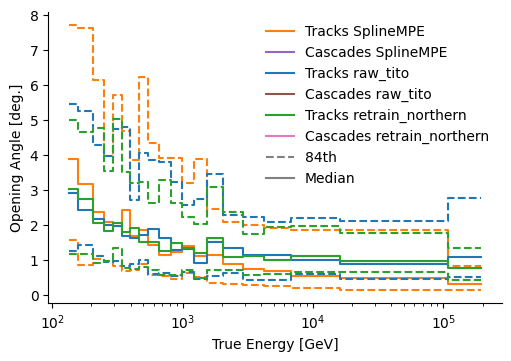

In [74]:
a.plot_resolution_fancy('direction', include_energy_hist=False)

IndexError: list index out of range

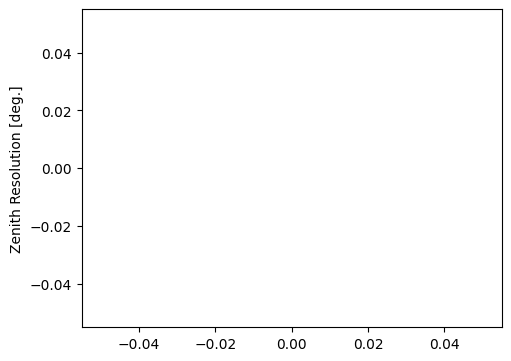

In [45]:
a.plot_resolution_fancy('zenith')

## Train on northern tracks from scratch

## Kaggle-trained evaluated on northern tracks

<Axes: xlabel='True Energy [GeV]', ylabel='Opening Angle [deg.]'>

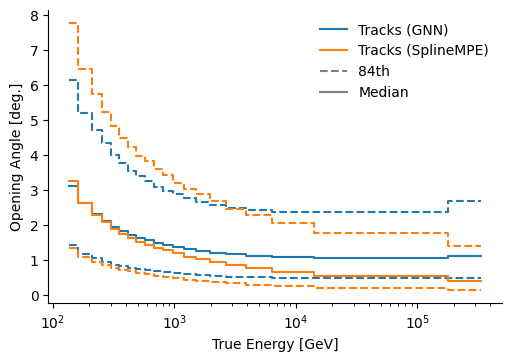

In [ ]:
df_selected = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_raw_tito_testFile5.csv')
database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'
plotting_obj = sensitivity_plots(df_selected, database)
plotting_obj.plot_resolution_fancy('direction')

In [ ]:
df_selected = add_energy(database, df_selected)
df_selected = add_spline_fit(database, df_selected)
df_selected = calculate_opening_angle(df_selected, key = 'gnn')

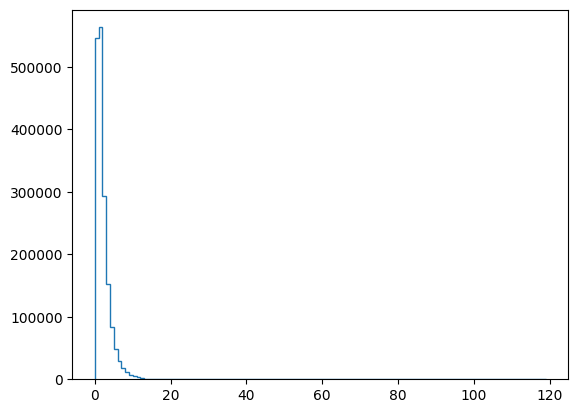

In [ ]:
a=plt.hist(df_selected['opening_angle'], bins = np.arange(0, 120, 1), histtype = 'step')

## Fine-tuning (retrain) of Kaggle-trained model on northern tracks

Text(0.5, 1.0, 'Fine tuning on northern data')

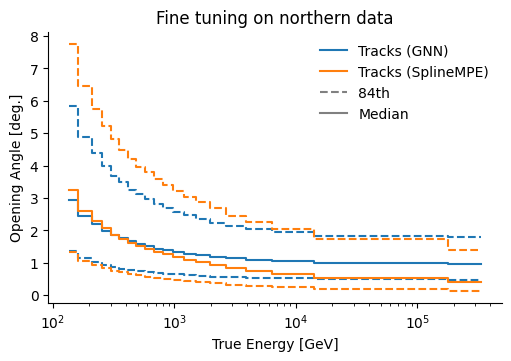

In [ ]:
df_selected = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_northern.csv')
database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'
plotting_obj = sensitivity_plots(df_selected, database)
plotting_obj.plot_resolution_fancy('direction')
plt.title('Fine tuning on northern data')

Text(0.5, 1.0, 'Fine tuning on northern data')

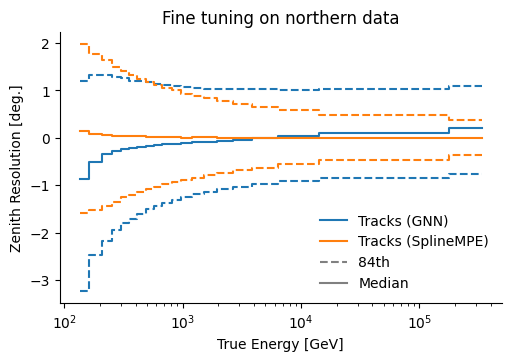

In [ ]:
df_selected = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_northern.csv')
database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'
plotting_obj = sensitivity_plots(df_selected, database)
plotting_obj.plot_resolution_fancy('zenith')
plt.title('Fine tuning on northern data')

In [9]:
from copy import deepcopy
import sqlite3
def calculate_opening_angle(df, key = 'gnn'):
    x = np.cos(df['azimuth']) * np.sin(df['zenith'])
    y = np.sin(df['azimuth']) * np.sin(df['zenith'])
    z = np.cos(df['zenith'])
    if key == 'gnn':
        dot_product = x*df['direction_x'] + y*df['direction_y'] + z*df['direction_z']
        norm = np.sqrt(df['direction_x']**2 + df['direction_y']**2 + df['direction_z']**2)
        angle = np.arccos(dot_product/norm)
    elif key == 'spline':
        x_spline = np.cos(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
        y_spline = np.sin(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
        z_spline = np.cos(df['zenith_spline_mpe_ic'])
        dot_product = x*x_spline + y*y_spline + z*z_spline
        norm = np.sqrt(x_spline**2 + y_spline**2 + z_spline**2)
        angle = np.arccos(dot_product/norm)
    return np.rad2deg(angle)

def add_spline_fit(original_df, db):
    df = deepcopy(original_df)
    df = df.sort_values('event_no').reset_index(drop = True)
    with sqlite3.connect(db) as con:
        # Read the table data into a Pandas DataFrame
        query = f"SELECT event_no, zenith_spline_mpe_ic, azimuth_spline_mpe_ic from spline_mpe_ic where event_no in {str(tuple(df['event_no']))}"
        truth = pd.read_sql(query,con).sort_values('event_no').reset_index(drop = True)
    
    # Add the spline fit to the DataFrame
    for column in truth.columns:
        if column not in df.columns:
            df[column] = truth[column]    
    return df

raw data read
retrain data read


Text(0, 0.5, 'Counts')

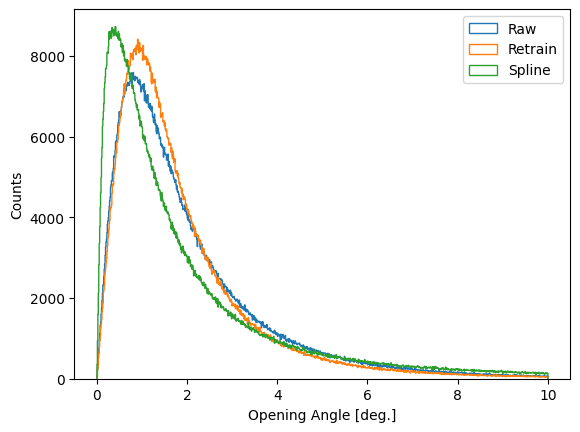

In [11]:
#df_raw = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_raw_tito_testFile5.csv')#
#df_raw = add_spline_fit(df_raw, database)
#print('raw data read')
#df_retrain = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_northern.csv')
#df_retrain = add_spline_fit(df_retrain, database)
#print('retrain data read')

raw_results = calculate_opening_angle(df_raw, key = 'gnn')
retrain_results = calculate_opening_angle(df_retrain, key = 'gnn')
spline_results = calculate_opening_angle(df_raw, key = 'spline')

bins=np.linspace(0, 10, 1000)
plt.hist(raw_results, bins=bins, histtype = 'step', label = 'Raw')
plt.hist(retrain_results, bins=bins, histtype = 'step', label = 'Retrain')
plt.hist(spline_results, bins=bins, histtype = 'step', label = 'Spline')
plt.legend()
plt.xlabel('Opening Angle [deg.]')
plt.ylabel('Counts')